# Simplest GAN ever

Welcome to the first exercise in GANs.

Remember than the **G** stands for _Generative_ network. So, we are interested in a generator. We want a network that can _create_ more data, according to some pre-defined distribution. However, this pre-defined distribution cannot be described analitically, only at a hight level, e.g. "My distribution is _images of cats_". So the _Generative_ network will have to learn this distribution from real data.

Before we dive into images, let's start with something much simpler: a **two**-dimensional distribution. In other words, "I want a network that can generate _points which lie on a circle_." Or _points which lie on a parabola_.

Let's see how we can achieve this with a GAN

In [1]:
# if you need the GPU, make this a markdown cell, or comment the following lines
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

## The real data

First, let's have a look at the real data, the one that we try to model. This consists of _2D points_, whose distribution is a parabola. Unlike pictures of cats, we can quickly "acquire" some of this data:

In [3]:
def sample_data(n=10000, scale=100):
    """Produce a numpy array of n 2D real samples"""
    x = np.random.random_sample(size=(n,))
    x = scale * (x - 0.5)
    y = x ** 2 + 10

    data = np.c_[x, y]
    return data

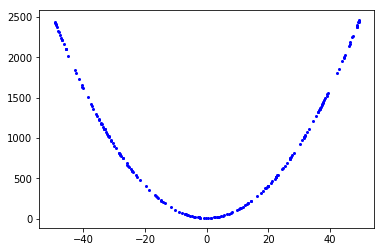

In [4]:
real = sample_data(200)
plt.plot(real[:, 0], real[:, 1], 'bo', markersize=2)

# The noise

Our network will have to learn that dependency between the `x` and the `y` dimensions. However, it cannot do so from nothing. It can, however, learn a mapping.

So the generator will take as input a noise vector `Z` and will transform it to look like the _real_ distribution above.

Let's have a look at the noise vector:

In [5]:
def sample_Z(n=10000, scale=100):
    """Produce a numpy array of n 2D random samples"""
    x = np.random.random_sample(size=(n,))
    x = scale * (x - 0.5)

    y = np.random.random_sample(size=(n,))
    y = scale * (y - 0.5)

    data = np.c_[x, y]
    return data

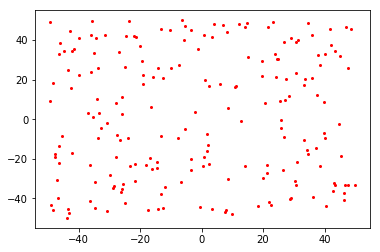

In [6]:
noise = sample_Z(200)
plt.plot(noise[:, 0], noise[:, 1], 'ro', markersize=2)

As you noticed, the function for sampling the noise is very similar to the one for sampling real data. In this case, the noise vector is initialized truly randomly. But what if it wasn't?

At a later stage, you can come back and modify the `sample_Z` function, in order to have a differently initialized vector.

## *G* stands for _Generator_

### TASK: Build up generator network. 

**Input:** a noise vector `Z`. 
 - The dimension of z could be smaller or the same with the label data. Theoretically the z could also be bigger than the label data, but then the generator is less meaningful since people use generator to map the low dimension data to high dimenstion, not the way around.
 - in our case, it is difficult to have a z of dimension much lower than 2 :). So the noise vector will also be of shape `[batch_size, 2]`

**Output:** sample data that should be the same dimension with label data (in this case, 2).

**Architecture:** you can build 2 or 3 layers in generator. 
 - There is no standard how many layers we should use. More layers can give better result, but also have the risk to overfit. Also, more layers mean more memory needed. In practial tasks, you have to try by yourself. 
 - For each layer, you can use fully connected layer or convolutional layer. You can call the function `tf.layers.dense` to build up one fully connected layer in tensorflow. Here is a detailed explanation and arguments for `tf.layers.dense` : https://www.tensorflow.org/api_docs/python/tf/layers/dense
 - You should give the inputs and the units to the function, and use `tf.nn.relu` or `tf.nn.leaky_relu` as activation function. But of course you can skip inputing the activation function and have a look what will happen in the result. 

In [7]:
def generator(Z, hsize=[16, 16], reuse=False):
    with tf.variable_scope("GAN/Generator", reuse=reuse):
        h1 = tf.layers.dense(Z, hsize[0], activation=tf.nn.leaky_relu) # layer 1
        h2 = tf.layers.dense(h1, hsize[1], activation=tf.nn.leaky_relu) # layer 2
        out = tf.layers.dense(h2, 2)

    return out

## *A* stands for _Adversarial_

Who is the adversary? A _Discriminator_ network. It's task is to say whether the data produced by the _Generator_ is real or fake.

### TASK: Build up discriminator network. 

**Input:** sample data or real data (ground truth). Input dimension: `[batch_size, 2]`

**Output:** [batch_size,1] dimension scalar. The discriminator should output one probability scalar to tell real or fake. If you feed in a batch, then the output is `[batch_size, 1]`.

**Architecture:** 3 or 4 layers. You can still use fully connected layer as what you have in generator. But notice that, the output of last layer must be `[batch_size, 1]`.

In [8]:
def discriminator(X, hsize=[16, 16], reuse=False):
    with tf.variable_scope("GAN/Discriminator", reuse=reuse):
        h1 = tf.layers.dense(X, hsize[0], activation=tf.nn.leaky_relu) # layer 1 
        h2 = tf.layers.dense(h1, hsize[1], activation=tf.nn.leaky_relu) # layer 2
        h3 = tf.layers.dense(h2, 2)
        out = tf.layers.dense(h3, 1)

    return out

## *N* stands for ... (trained) _Network_

In other words, to have a useful network, we need to train it. In order to train it, we need some inputs (real data X and noise vector Z) and some loss(es). And this is where the fun starts

In [9]:
X = tf.placeholder(tf.float32,[None,2])
Z = tf.placeholder(tf.float32,[None,2])

Call the generator and discriminator :

In [10]:
G_sample = generator(Z)
real_logits = discriminator(X)
fake_logits = discriminator(G_sample, reuse=True)

### TASK: complete the generator loss and discriminator loss according to the objective function.  

Note that: when discriminator is updated, the generator is fixed; And when generator is updated, the discriminator is fixed. This is important!

#### Discriminator loss: 

![Discriminator loss image](../images/discriminator_loss.png)

In other words, the discriminator tries to output `1` for the real images and `0` for the fake ones. The functions `tf.ones_like` and `tf.zeros_like` can come in useful.

You can use the function `tf.nn.sigmoid_cross_entropy_with_logits` to compute the cross entropy.

In [11]:
disc_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=tf.ones_like(real_logits)) + \
                tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits))
            )

#### Generator Loss:

![Generator loss image](../images/generator_loss.png)

Or, in natural language, the generator tries to make the output of the discriminator be `1` for the generated images.

In [12]:
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits)))

Collect the trainable variables and build the optimizer:

Note: there are many different optimizer in tensorflow such as AdadeltaOptimizer, AdamOptimizer, GradientDescentOptimizer. You can play with different optimizer and compare the results. But please notice that different optimizer might require different arguments. Please google it first to get the details.

Having 2 different optimizers for G and D means that each is kept constant when the other updates

In [13]:
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss, var_list=gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss, var_list=disc_vars) # D Train step


Visualize results:

In [14]:
from IPython import display

In [15]:
batch_size = 1000
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [16]:
sess.run(tf.global_variables_initializer())
step = 0

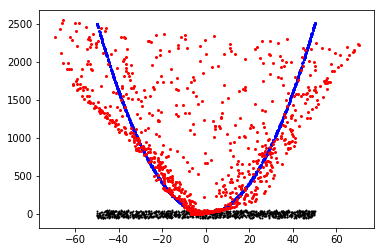

In [17]:
for i in range(10001):
    step += 1
    X_batch = sample_data(n=batch_size)
    Z_batch = sample_Z(n=batch_size)

    # Train discriminator 
    _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})

    # Train generator
    _, gloss, np_G_sample = sess.run([gen_step, gen_loss, G_sample], feed_dict={Z: Z_batch})

    
    if i % 1000 == 0:
        print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f" % (step, dloss, gloss))
        plt.clf()
        plt.plot(X_batch[:,0], X_batch[:,1], 'bo', 
                 Z_batch[:,0], Z_batch[:, 1], 'k.',
                 np_G_sample[:,0], np_G_sample[:,1], 'ro',
                 markersize=2)
        display.display(plt.gcf())
        display.clear_output(wait=True)

## Tune to your liking

So, now you have seen the GAN training. If you're not happy with the above result, feel free to run the above cell once more, to train the GAN further.

Or you can go back and modify the `sample_Z` function, to start with a better noise vector. Note that if you do this, you'll probably have to re-start the kernel, or your GAN will continue training.

Have fun!